In [1]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dill
from typing import List
import scipy.stats as sts
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

import util
from pathlib import Path
from class_manipulates_path import ManipulatePath
from class_preprocessing_refactor import Preprocessing
from class_format_data import FormatData
util.init()

current_path = sys.path[0]

In [2]:
def plot_variable(df, column_name, intervalos=None):
    """
    Plota um gráfico de dispersão para uma variável de um DataFrame.

    Parâmetros:
        - df: DataFrame pandas contendo os dados.
        - column_name: Nome da coluna que você deseja plotar.
        - intervalos: Lista de intervalos para plotar linhas verticais.
    """
    plt.figure(figsize=(20, 10))
    plt.scatter(df.index.values, df[column_name].values, color='darkcyan', alpha=0.5)
    plt.xlabel('Índice')
    plt.ylabel(column_name)
    plt.title(f'Gráfico de dispersão para a variável "{column_name}"')


    # Plotar linhas verticais para cada intervalo
    if intervalos:
        for intervalo in intervalos:
            plt.axvline(x=intervalo, linestyle='--', color='red')

    plt.show()

In [3]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [4]:
manipulate_path = ManipulatePath()

preprocessing = Preprocessing()

format_data = FormatData()

path_raw_data = manipulate_path.get_path_raw_data()

abnormal_classes_codes = [1, 2, 5, 6, 7, 8]

In [5]:
# Gets all real instances but maintains only those with any type of undesirable event
real_instances = pd.DataFrame(class_and_file_generator(path_raw_data, 
                                                       real=True,
                                                       simulated=False, 
                                                       drawn=False),
                              columns=['class_code', 'instance_path'])
real_instances = real_instances.loc[real_instances.iloc[:,0].isin(abnormal_classes_codes)].reset_index(drop=True)

In [6]:
real_instances[real_instances["class_code"] == 1]

,class_code,instance_path
0,1,c:\Users\marce\Documents\MEGA\0_PUC-Rio\2_Peri...
1,1,c:\Users\marce\Documents\MEGA\0_PUC-Rio\2_Peri...
2,1,c:\Users\marce\Documents\MEGA\0_PUC-Rio\2_Peri...
3,1,c:\Users\marce\Documents\MEGA\0_PUC-Rio\2_Peri...
4,1,c:\Users\marce\Documents\MEGA\0_PUC-Rio\2_Peri...


In [7]:
real_instances[real_instances["class_code"] == 1]["instance_path"].values

array([WindowsPath('c:/Users/marce/Documents/MEGA/0_PUC-Rio/2_Periodo/2_Data Science/2_Trabalho_Final/3_3W/1_data/1_raw_data/1/WELL-00001_20140124093303.csv'),
       WindowsPath('c:/Users/marce/Documents/MEGA/0_PUC-Rio/2_Periodo/2_Data Science/2_Trabalho_Final/3_3W/1_data/1_raw_data/1/WELL-00002_20140126161944.csv'),
       WindowsPath('c:/Users/marce/Documents/MEGA/0_PUC-Rio/2_Periodo/2_Data Science/2_Trabalho_Final/3_3W/1_data/1_raw_data/1/WELL-00006_20170731180930.csv'),
       WindowsPath('c:/Users/marce/Documents/MEGA/0_PUC-Rio/2_Periodo/2_Data Science/2_Trabalho_Final/3_3W/1_data/1_raw_data/1/WELL-00006_20170731220432.csv'),
       WindowsPath('c:/Users/marce/Documents/MEGA/0_PUC-Rio/2_Periodo/2_Data Science/2_Trabalho_Final/3_3W/1_data/1_raw_data/1/WELL-00006_20180617200257.csv')],
      dtype=object)

In [8]:
falha = 1

file_paths = real_instances[real_instances["class_code"] == falha]["instance_path"].values
df_output = pd.DataFrame()

for file_path in file_paths:
    df_data = pd.read_csv(file_path)

    df_data = FormatData.set_index_dataframe(df_data=df_data,
                                         column_name="timestamp")
    quantidade = (df_data['class'] == falha).sum()
    print(f"1 se repete {quantidade}")
    print(f"Index min {df_data.index.min()} index max {df_data.index.max()}")
    
    df_output = pd.concat([df_output, df_data], axis=0)

1 se repete 4603
Index min 2014-01-24 09:33:03 index max 2014-01-25 01:47:30
1 se repete 2929
Index min 2014-01-26 16:19:44 index max 2014-01-26 23:00:00
1 se repete 1205
Index min 2017-07-31 18:09:30 index max 2017-08-01 20:45:00
1 se repete 861
Index min 2017-07-31 22:04:32 index max 2017-08-01 20:19:27
1 se repete 819
Index min 2018-06-17 20:02:57 index max 2018-06-18 11:00:00


In [9]:
df_output = df_output[~df_output.index.duplicated()]

In [10]:
df_output.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
timestamp,,,,,,,,,
2014-01-24 09:33:03,0.0,18433410.0,116.8718,9397031.0,74.80031,-300917.8,NaN,0.0,0.0
2014-01-24 09:33:04,0.0,18433410.0,116.8718,9397031.0,74.80031,-300917.8,NaN,0.0,0.0
2014-01-24 09:33:05,0.0,18433410.0,116.8718,9397032.0,74.80031,-300917.8,NaN,0.0,0.0
2014-01-24 09:33:06,0.0,18433410.0,116.8718,9397033.0,74.80031,-300917.8,NaN,0.0,0.0
2014-01-24 09:33:07,0.0,18433410.0,116.8718,9397033.0,74.80031,-300917.8,NaN,0.0,0.0


In [11]:
df_aux = df_output.drop(columns=["QGL", "T-JUS-CKGL"])
df_aux

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,class
timestamp,,,,,,,
2014-01-24 09:33:03,0.000000e+00,18433410.0,116.8718,9397031.0,74.80031,-300917.8,0.0
2014-01-24 09:33:04,0.000000e+00,18433410.0,116.8718,9397031.0,74.80031,-300917.8,0.0
2014-01-24 09:33:05,0.000000e+00,18433410.0,116.8718,9397032.0,74.80031,-300917.8,0.0
2014-01-24 09:33:06,0.000000e+00,18433410.0,116.8718,9397033.0,74.80031,-300917.8,0.0
2014-01-24 09:33:07,0.000000e+00,18433410.0,116.8718,9397033.0,74.80031,-300917.8,0.0
...,...,...,...,...,...,...,...
2018-06-18 10:59:56,-1.180116e+42,20647810.0,118.2188,10136700.0,71.27952,4108865.0,1.0
2018-06-18 10:59:57,-1.180116e+42,20647810.0,118.2194,10137410.0,71.27949,4108866.0,1.0
2018-06-18 10:59:58,-1.180116e+42,20647810.0,118.2201,10138120.0,71.27946,4108866.0,1.0


In [12]:
for column_name in df_aux.columns:
    percent = Preprocessing.check_null_dataframe(df_data=df_aux, column_name=column_name)
    print(f"{column_name} null data is {percent}")

P-PDG null data is 0.0
P-TPT null data is 0.0
T-TPT null data is 0.0
P-MON-CKP null data is 0.0
T-JUS-CKP null data is 0.0
P-JUS-CKGL null data is 0.0
class null data is 4.459575935183589


In [13]:
df_aux = df_aux.dropna()
df_aux.shape

(221692, 7)

In [14]:
for column_name in df_aux.columns:
    percent = Preprocessing.check_column_low_variance(df_data=df_output, column_name=column_name)
    print(f"{column_name} low variance is {percent}")

P-PDG low variance is 0
P-TPT low variance is 0
T-TPT low variance is 0
P-MON-CKP low variance is 0
T-JUS-CKP low variance is 0
P-JUS-CKGL low variance is 0
class low variance is 0


In [15]:
df_aux["class"] = df_aux["class"].replace(101, 1)

C:\Users\marce\AppData\Local\Temp\ipykernel_49028\311632643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux["class"] = df_aux["class"].replace(101, 1)


In [16]:
contagem_classes = df_aux['class'].value_counts()

# Calcular a porcentagem de cada classe
porcentagem_classes = contagem_classes / len(df_aux) * 100
porcentagem_classes

class
0.0    66.432257
1.0    33.567743
Name: count, dtype: float64

In [17]:
# Separar as features (X) e os rótulos (y)
X = df_aux.drop('class', axis=1)
y = df_aux['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

df_train = X_train.copy()
df_train["class"] = y_train

df_test = X_test.copy()
df_test["class"] = y_test

In [18]:
# define AnomalyDetection Class
class AnomalyDetection:

    def __init__(self,
                 train: pd.DataFrame,
                 n_components: int,
                 columns: List[str],
                 alpha: float=0.05) -> None:
        """
        class to detect anomalies using PCA

        Parameters
        ----------
        train : pd.DataFrame
            data to train PCA
        n_components : int
            number of components to be
            held
        alpha : float, optional
            significance level, by default 0.05
        """
        self.train = train
        self.n = n_components
        self.confidence = 1-alpha
        self.columns = columns

    def fit_model(self) -> None:
        """
        fits the PCA model
        """
        # fits with all components
        self.pipePCA_all = Pipeline([
            ('scaler', RobustScaler()),
            ('model', PCA())
        ])

        # fits with only the desired components
        self.pipePCA = Pipeline([
            ('scaler', RobustScaler()),
            ('model', PCA(n_components=self.n))
        ])

        self.pipePCA_all.fit(self.train.values)
        self.pipePCA.fit(self.train.values)

        # calculate confidence level for SPE
        self.max_SPE()

        # calculates the statistical limit for T2
        self.max_T2()

        with open(os.path.join(current_path, "models", "pipePCA_all.dill"), 'wb') as file:
            dill.dump(self.pipePCA_all, file)
        
        with open(os.path.join(current_path, "models", "pipePCA.dill"), 'wb') as file:
            dill.dump(self.pipePCA, file)

    def calculate_T2(self,
                      anomaly_data: pd.DataFrame) -> None:
        """
        calculates the T2 statistics for the
        inputted data

        Parameters
        ----------
        anomaly_data : pd.DataFrame
            inputted data
        
        """
        self.test = anomaly_data

        # preprare T2 calculation
        self.P = self.pipePCA['model'].components_.T
        lambdas = self.pipePCA['model'].explained_variance_

        # apply scaler on anomalous data
        self.x_std = self.pipePCA['scaler'].transform(self.test[self.columns].values)

        # apply algebra to calculate T2
        t2s = np.array([
            xi.dot(self.P).dot(np.diag(lambdas**(-1))).dot(self.P.T).dot(xi.T)
            for xi in self.x_std
        ])

        # store t2s
        self.test['Hotelling_T2'] = t2s

    def max_T2(self) -> None:
        """
        calculates the maximum T2
        """
        N = self.pipePCA['model'].n_components_
        n = self.train.shape[0]
        factor = (N*(n-1)) / (n-N)
        self.pipePCA._max_t2 = sts.f.ppf(self.confidence, N, n-N)

    def calculate_SPE(self) -> None:
        """
        calculates the Squared Prediction Error for the 
        anomalous samples
        """
        self.r = self.x_std.dot(np.identity(self.P.shape[0])-self.P.dot(self.P.T))

        SPE = []
        for i in range(self.r.shape[0]):
            SPE.append(self.r[i].dot(self.r[i].T))

        self.test['SPE'] = SPE

    def calculate_contributions(self) -> None:
        """
        calculate individual contributions for SPE
        """
        self.contributions = pd.DataFrame(self.r ** 2)
        self.contributions.columns = self.columns
        self.contributions.index = self.test.index

    def plot_pcs(self) -> None:
        """
        plots the scatterplot of the data
        """

        # make the transformation
        self.norm_pcs = pd.DataFrame(
            self.pipePCA.transform(self.train),
            index=self.train.index,
            columns=[f'PC{k+1}' for k in range(self.pipePCA['model'].n_components_)])
        self.anom_pcs = pd.DataFrame(
            self.pipePCA.transform(self.test[self.columns]),
            index=self.test.index,
            columns=[f'PC{k+1}' for k in range(self.pipePCA['model'].n_components_)])

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(x=self.anom_pcs['PC1'], y=self.anom_pcs['PC2'], color='red', marker='x', alpha=0.5,
                   label='Potential Anomalies')
        ax.scatter(x=self.norm_pcs['PC1'], y=self.norm_pcs['PC2'], color='darkgreen', marker='o', alpha=0.8,
                   label='Normal Operation')

        ax.set_xlabel('PC1', size=24)
        ax.set_ylabel('PC2', size=24)
        ax.set_title('Projection of Fuel Gas Consumption\nPrincipal Components', size=28)
        ax.legend(loc='best', prop={'size': 16}, facecolor='white')
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)

    def max_SPE(self) -> None:
        """
        calculates the maximum limit for SPE
        """
        lambdas_all = self.pipePCA_all['model'].explained_variance_

        # calculate theta
        theta1 = self.theta(lambdas_all, self.n, 1, self.train.shape[1])
        theta2 = self.theta(lambdas_all, self.n, 2, self.train.shape[1])
        theta3 = self.theta(lambdas_all, self.n, 3, self.train.shape[1])

        # calculate h0 parameter
        h0 = 1 - ((2 * theta1 * theta3) / (3 * (theta2 ** 2)))
        
        # calculate critical value for desired confidence
        critical_alpha = sts.norm.ppf(self.confidence)

        # calculate max SPE
        self.pipePCA._max_spe = theta1 * ((((critical_alpha * np.sqrt(2 * theta2 * (h0 ** 2)))/
                              theta1) + 1 + (theta2 * h0 * (h0 - 1))/(theta1 ** 2)) ** (1/ h0 ))

    @staticmethod
    def theta(lambdas: list, n: int, idx: int, no_sensors: int) -> float:
        """
        calculates the theta parameter

        Parameters
        ----------
        lambdas : list
            list of eigenvalues
        n : int
            number of components held
        idx : int
            theta desired
        no_sensors : int
            number of sensors

        Returns
        -------
        float
            value of theta
        """
        theta = 0
        for k in range(n, no_sensors):
            theta += (lambdas[k] ** idx)

        return theta
    
    def plot_control_charts(self) -> None:
        """
        plots the control charts of T2 and SPE
        """
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(2, 1, 1)
        ax.plot(self.test['Hotelling_T2'], 'k-', lw=0.7)
        ax.axhline(y = self.pipePCA._max_t2, color='red', lw=2, ls='--')
        ax.set_ylabel('Hotellings T²', size=24)
        ax.set_title('Hotelling T² Statistics Plot - {} % confidence level'.
                     format(self.confidence*100), size=28)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        plt.grid(True, alpha=0.5)

        ax = fig.add_subplot(2, 1, 2)
        ax.plot(self.test['SPE'], 'k-', lw=0.7)
        ax.axhline(y = self.pipePCA._max_spe, color='red', lw=2, ls='--')
        ax.set_ylabel('Squared Prediction Error', size=24)
        ax.set_title('SPE Statistics Plot - {} % confidence level'.
                     format(self.confidence*100), size=28)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        plt.grid(True, alpha=0.5)

        plt.tight_layout()
        plt.show()

    def plot_contributions(self, idx: object) -> None:
        """
        plots a bar plot of the contributions
        for a selected index

        Parameters
        ----------
        idx : object
            index of the point
        """
        # extract point
        series = self.contributions.loc[[idx],:].T
        series.columns = ['contributions']
        
        # sort values
        series.sort_values(by=['contributions'], inplace=True)
        
        # make the plot
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1)
        ax.barh(y=series.index, width=series['contributions'].values, color='orange')
        ax.set_xlabel('Contribution to SPE', size=24)
        ax.set_title('Individual Tag contributions to SPE', size=28)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)

# define AnomalyDetection Class
class RealTimeAnomalyDetection:

    def __init__(self,
                 n_components: int,
                 columns: List[str],
                 alpha: float=0.05) -> None:
        """
        class to detect anomalies using PCA

        Parameters
        ----------
        train : pd.DataFrame
            data to train PCA
        n_components : int
            number of components to be
            held
        alpha : float, optional
            significance level, by default 0.05
        """
        self.n = n_components
        self.confidence = 1-alpha
        self.columns = columns
        self.load_model()

    def load_model(self):
        with open(os.path.join(current_path, "models", "pipePCA_all.dill"), 'rb') as file:
            self.pipePCA_all = dill.load(file)

        with open(os.path.join(current_path, "models", "pipePCA.dill"), 'rb') as file:
            self.pipePCA = dill.load(file)
    
    def calculate_online_anomalies(self, data_online: pd.DataFrame) -> pd.DataFrame:
        """
        Calculates T2, SPE, and variable contributions for online data.

        Parameters
        ----------
        data_online : pd.DataFrame
            New data for which anomalies need to be detected.

        Returns
        -------
        pd.DataFrame
            A DataFrame with T2, SPE, and variable contributions for each sample in data_online.
        """
        # preprare T2 calculation
        self.P = self.pipePCA['model'].components_.T
        lambdas = self.pipePCA['model'].explained_variance_

        # Apply the same preprocessing steps used during training on data_online
        x_std_online = self.pipePCA['scaler'].transform(data_online[self.columns].values)
        
        # Apply algebra to calculate T2 for online data
        t2s_online = np.array([
            xi.dot(self.P).dot(np.diag(lambdas**(-1))).dot(self.P.T).dot(xi.T)
            for xi in x_std_online
        ])
        
        # Calculate SPE for online data
        r_online = x_std_online.dot(np.identity(self.P.shape[0])-self.P.dot(self.P.T))
        spe_online = np.array([ri.dot(ri.T) for ri in r_online])
        
        # Calculate variable contributions for online data
        contributions_online = pd.DataFrame(r_online ** 2)
        contributions_online.columns = self.columns
        contributions_online.index = data_online.index
        contributions_online.index.name = "Timestamp"
        
        # Create a DataFrame to store the results
        results_df = pd.DataFrame({
            'Timestamp': data_online.index,
            'T2': t2s_online,
            'SPE': spe_online
        })
        results_df.set_index('Timestamp', inplace=True)
        # Add the variable contributions to the results DataFrame
        # results_df = pd.concat([results_df, contributions_online], axis=1)
        
        return results_df, contributions_online

In [19]:
full_data_train = df_train.copy()
norm_data_train = df_train[df_train["class"] == 0].copy()

norm_data_train = norm_data_train.drop(columns=["class"])

anom_data_train = df_train[(df_train["class"] == 1)].copy()
anom_data_train = anom_data_train.drop(columns=["class"])

In [20]:
# let's try simple PCA first
pipePCA = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(random_state=2))
])

pipePCA.fit(norm_data_train.values)

Pipeline(steps=[('scaler', RobustScaler()), ('pca', PCA(random_state=2))])

In [21]:
pipePCA['pca'].explained_variance_ratio_.cumsum()

array([0.84432456, 0.943681  , 0.99996395, 0.99999023, 0.99999956,
       1.        ])

In [22]:
# create class instance and fit model
n_components = 3
anomaly = AnomalyDetection(train=norm_data_train, n_components=n_components, columns=norm_data_train.columns)
anomaly.fit_model()
anomaly.calculate_T2(anomaly_data=anom_data_train)
anomaly.calculate_SPE()
anomaly.calculate_contributions()

c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


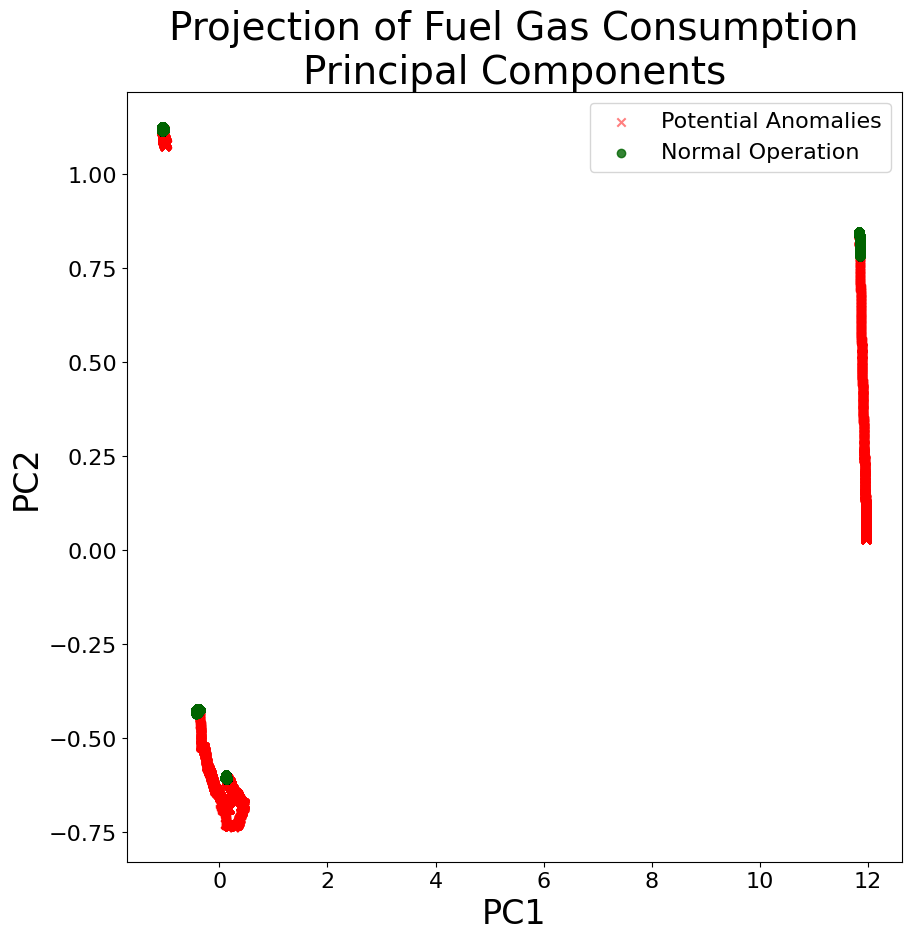

In [23]:
anomaly.plot_pcs()

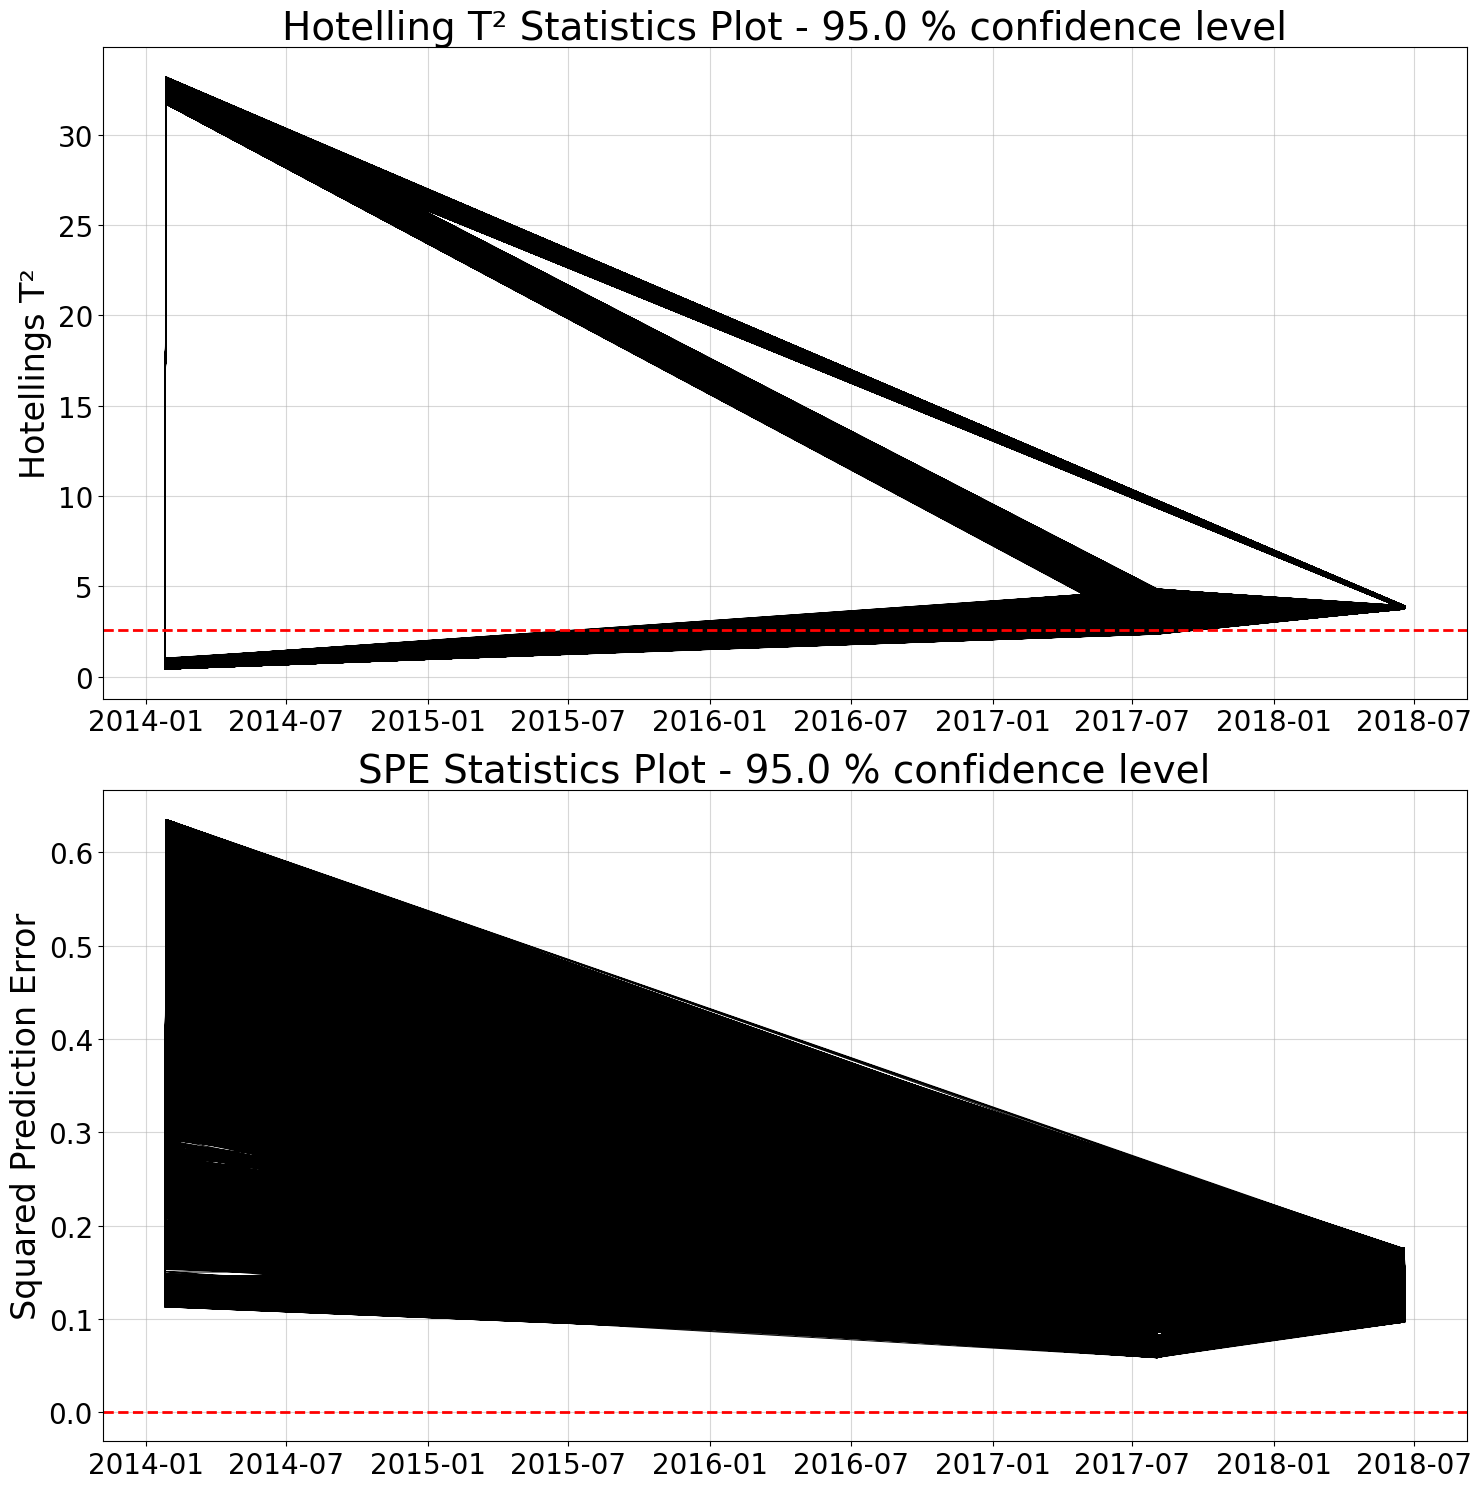

In [24]:
anomaly.plot_control_charts()

In [25]:
realtime_anomaly = RealTimeAnomalyDetection(n_components=n_components, columns=norm_data_train.columns)

In [26]:
print(realtime_anomaly.pipePCA._max_t2)
print(realtime_anomaly.pipePCA._max_spe)

2.604995401927457
0.0006751644633553434


In [27]:
# Calculate the SPE and T2 statistics for all data
# Additionally, variable contributions are also computed. All these results are per timestamp.
results_df, contributions_online = realtime_anomaly.calculate_online_anomalies(full_data_train)

In [28]:
results_df["Anomaly"] = 0  # Initialize the "Anomaly" column with value 0

# Apply the condition to identify anomalies and set the value to 1 when the condition is true
results_df.loc[(results_df["T2"] > realtime_anomaly.pipePCA._max_t2) & (results_df["SPE"] > realtime_anomaly.pipePCA._max_spe), "Anomaly"] = 1
results_df.head()

,T2,SPE,Anomaly
Timestamp,,,
2017-08-01 19:45:13,4.327967,0.069566,1
2018-06-18 02:18:28,3.715034,0.178528,1
2014-01-26 22:45:15,33.078266,0.616076,1
2014-01-24 20:17:48,1.059055,0.178313,0
2017-07-31 18:59:31,2.131466,0.194658,0


In [29]:
full_data_train["PRED_ANOMALY"] = results_df["Anomaly"]

In [30]:
full_data_train["PRED_ANOMALY"]

Timestamp
2017-08-01 19:45:13    1
2018-06-18 02:18:28    1
2014-01-26 22:45:15    1
2014-01-24 20:17:48    0
2017-07-31 18:59:31    0
                      ..
2018-06-17 21:10:02    1
2017-07-31 20:54:53    0
2018-06-18 01:19:39    1
2017-08-01 05:08:21    0
2014-01-24 19:12:32    0
Name: PRED_ANOMALY, Length: 155184, dtype: int64

In [32]:
accuracy_score(full_data_train['class'].values, full_data_train["PRED_ANOMALY"].values)

0.6856828023507578

In [43]:
f1_score(full_data_train['class'].values,  full_data_train["PRED_ANOMALY"].values, average="micro")

0.6856828023507578

In [42]:
precision = precision_score(full_data_train['class'].values,  full_data_train["PRED_ANOMALY"].values, average=None)
recall = recall_score(full_data_train['class'].values,  full_data_train["PRED_ANOMALY"].values, average=None)
f1 = f1_score(full_data_train['class'].values,  full_data_train["PRED_ANOMALY"].values, average=None)

for i in range(len(precision)):
    print(f'Classe {i}:')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'F1-score: {f1[i]}\n')

Classe 0:
Precision: 0.8203177523796044
Recall: 0.6746304271912467
F1-score: 0.740375249500998

Classe 1:
Precision: 0.523543699663357
Recall: 0.7075558627044459
F1-score: 0.6017976537434792



In [33]:
# Calculate the SPE and T2 statistics for all data
# Additionally, variable contributions are also computed. All these results are per timestamp.
results_df, contributions_online = realtime_anomaly.calculate_online_anomalies(df_test)

results_df["Anomaly"] = 0  # Initialize the "Anomaly" column with value 0

# Apply the condition to identify anomalies and set the value to 1 when the condition is true
results_df.loc[(results_df["T2"] > realtime_anomaly.pipePCA._max_t2) & (results_df["SPE"] > realtime_anomaly.pipePCA._max_spe), "Anomaly"] = 1

df_test["PRED_ANOMALY"] = results_df["Anomaly"]

In [35]:
accuracy_score(df_test['class'].values, df_test["PRED_ANOMALY"].values)

0.6869399170024658

In [44]:
f1_score(df_test['class'].values,  df_test["PRED_ANOMALY"].values, average="micro")

0.6869399170024658

In [36]:
precision = precision_score(df_test['class'].values,  df_test["PRED_ANOMALY"].values, average=None)
recall = recall_score(df_test['class'].values,  df_test["PRED_ANOMALY"].values, average=None)
f1 = f1_score(df_test['class'].values,  df_test["PRED_ANOMALY"].values, average=None)

In [37]:
for i in range(len(precision)):
    print(f'Classe {i}:')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'F1-score: {f1[i]}\n')

Classe 0:
Precision: 0.821613436123348
Recall: 0.6753955141117625
F1-score: 0.7413636758878551

Classe 1:
Precision: 0.524910560487611
Recall: 0.7097872340425532
F1-score: 0.6035077028545313



# Só PCA

In [38]:
norm_data_train

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL
timestamp,,,,,,
2018-06-18 02:18:28,-1.180116e+42,20787460.0,117.9135,10098550.0,70.90231,4068438.0
2014-01-24 20:17:48,0.000000e+00,18437500.0,116.9145,9388465.0,75.09396,-300917.8
2017-07-31 18:59:31,4.485805e+07,18373560.0,118.4565,2538562.0,78.89034,1281834.0
2017-07-31 18:54:59,4.485805e+07,18373560.0,118.4255,2538446.0,78.88868,1281451.0
2014-01-24 19:25:40,0.000000e+00,18453360.0,116.8815,9399409.0,74.91436,-300917.8
...,...,...,...,...,...,...
2018-06-17 21:10:02,-1.180116e+42,20827360.0,117.8949,10128780.0,70.86764,4042256.0
2017-07-31 20:54:53,4.485805e+07,18373560.0,118.5084,2541521.0,78.93248,1291580.0
2018-06-18 01:19:39,-1.180116e+42,20787460.0,117.9258,10104580.0,71.00772,4061116.0


In [39]:
pca = PCA(n_components=2, random_state=0)
x_train_pca = pd.DataFrame(pca.fit_transform(norm_data_train))
x_train_pca.index = x_train_pca.index

In [40]:
df_restored = pd.DataFrame(pca.inverse_transform(x_train_pca), index=x_train_pca.index)

In [41]:
from scipy.stats import multivariate_normal
# Ajustar a PCA apenas aos dados normais
pca = PCA(n_components=1, random_state=42)
pca.fit(norm_data_train)

# Calcula as projeções dos dados normais e anômalos nos componentes principais
projections_norm = pca.transform(norm_data_train)
projections_anorm = pca.transform(anom_data_train)

# Calcula a matriz de covariância manualmente
mean_norm = np.mean(projections_norm, axis=0)
cov_norm = np.cov(projections_norm, rowvar=False)
cov_norm += np.eye(cov_norm.shape[0]) * 1e-6  # Adiciona uma pequena constante para garantir positividade definida

# Calcula a densidade de probabilidade multivariada para os dados normais
mv_density = multivariate_normal(mean=mean_norm, cov=cov_norm, allow_singular=True)

# Define um limiar para identificar anomalias
limiar = mv_density.pdf(mean_norm)

# Identifica anomalias nos dados anômalos
anomalias_indices = np.where(mv_density.pdf(projections_anorm) < limiar)[0]

# Imprime os índices das anomalias
print("Índices das anomalias:", anomalias_indices)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Hotelling_T2
- SPE
